In [21]:
import os
import errno

import numpy as np

import deepcell
import matplotlib.pyplot as plt

from deepcell.datasets.tracked import hek293,nih_3t3_bench,nih_3t3,hek293_bench,hela_s3_bench,raw2647_bench
from deepcell.datasets.cytoplasm import hela,nih_3t3,cho
from PIL import Image
import imageio
import cv2
import random

import torch
import torchvision.transforms.functional as TF

from skimage import io
import tifffile as tiff

In [89]:
def gt_to_pos(track):
    black_im = np.zeros_like(track,dtype=np.uint8)
    frames = []
    for k in range(track.shape[0]):
        #print(k)
        unique_values, unique_counts = np.unique(track[k], return_counts=True)
        #print('u',unique_values)
        ind_list=[]
        for j in unique_values:
            indices = np.argwhere(track[k] == j)
            new_ind= indices[:, :-1]
            m_ind= mean_ind(new_ind)
            if j!=0:
                ind_list.append(m_ind)
        im_paint=black_im[k]
        image_tensor = im_paint

        # Define the radius of the ball
        radius = 2

        # Define the color of the ball (white)
        color = (255, 255, 255)

        # Define the list of positions
        positions = ind_list

        # Loop over the positions and draw a circle around each one
        for position in positions:
            # Convert the position to integer coordinates
            x, y = int(position[0]), int(position[1])

            # Draw a circle with the given radius and color
            for i in range(-radius, radius+1):
                for j in range(-radius, radius+1):
                    if i**2 + j**2 <= radius**2:
                        try:
                            image_tensor[x+i, y+j, :] = 255
                        except IndexError:
                            pass#print('IndErr',i,j)

        # Convert the numpy array to an image and display it
        black_im[k]=image_tensor
        im=image_tensor.squeeze()
        frame = Image.fromarray(im)
        frames.append(frame)

# Save the list of frames as a gif

        #plt.imshow(im, cmap='gray')
        #plt.show()
    #imageio.mimsave('video.gif', frames)
    return black_im,ind_list

    
def mean_ind(ind):
    l=len(ind)
    return np.sum(ind,axis=0)/l


def downsample_save_cyto(v_t,name,pos=False,vid=False,vid_nr=0,alt=0):


    # Load the video tensor
    video_tensor = v_t

    # Define the downsampling factor
    downsample_factor = 3

    # Define the pooling layer
    pooling_layer = torch.nn.MaxPool2d(kernel_size=downsample_factor, stride=downsample_factor)

    # Downsample the video tensor using max pooling
    downsampled_tensor = []
    for i in range(video_tensor.shape[0]):
        frame = video_tensor[i, :, :, :]
        frame = frame.astype('float32')
        frame = TF.to_pil_image(frame.squeeze())
        frame = TF.resize(frame, (150, 150))
        #print('frame_size',frame.size)
        frame = TF.to_tensor(frame).unsqueeze(0)
        #frame = pooling_layer(frame)
        downsampled_tensor.append(frame)
    downsampled_tensor = torch.cat(downsampled_tensor, dim=0)
    downsampled_tensor = downsampled_tensor.permute(0, 2, 3, 1).squeeze()
    #print('down_shape',downsampled_tensor.shape)
    # Save every 5 consecutive frames to a file
    num_frames = downsampled_tensor.shape[0]
    for i in range(0, num_frames-5, 1):
        frames_to_save = downsampled_tensor[i:i+5]
        single_frame=downsampled_tensor[i]
        frames_to_save = frames_to_save.numpy()
        #print('f_to_s',frames_to_save.shape)
        path=cons_path(i,name,pos,vid,vid_nr,alt)
        #print('path',path)
        np.save(path, frames_to_save)
        
        if pos:
            pos_t=2
            path2=cons_path(i,name,pos_t,vid,vid_nr,alt)
            #print('path2',path2)
            np.save(path2, single_frame)
        else:
            if random.random() < 1/6:
                pos_t=2
                path2=cons_path(i,name,pos_t,vid,vid_nr,alt)
                #print('path3',path2)
                np.save(path2, single_frame)
            
            
            
    return 0



def cons_path(i,name,pos,vid,vid_nr,alt):
    #print('pos',pos)
    if pos==True:
        pre='posit/'
    elif pos==2:
        print('pos2',pos)
        pre='emb_train/'
        i = np.random.randint(1, 100001)
        return pre+str(i)+'.npy'
    else:
        pre='images/'
    
    
    mid=name+'/'
    
    if vid:
        end='vn_'+str(vid_nr)+'_alt'+alt+'_'+str(i)+'.npy'
    else:
        end='alt'+alt+'_'+str(i)+'.npy'
    return pre+mid+end

def verify(path1,path2,single=None):
    
    if single:
        tensor1 = np.load(path1)
        tensor2 = np.load(path2)

        # Create a figure with subplots to display the frames side by side
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

        # Loop over each frame and display them in the subplots
        
        # Display the frame from the first tensor in the left subplot
        axs[0].imshow(tensor1, cmap="gray")
        axs[0].axis("off")

        # Display the frame from the second tensor in the right subplot
        axs[1].imshow(tensor2, cmap="gray")
        axs[1].axis("off")

        # Show the figure with the subplots
        plt.show()
        

    # Load the tensors from the .npy files
    tensor1 = np.load(path1)
    tensor2 = np.load(path2)

    # Create a figure with subplots to display the frames side by side
    fig, axs = plt.subplots(nrows=tensor1.shape[0], ncols=2, figsize=(10, 20))

    # Loop over each frame and display them in the subplots
    for i in range(tensor1.shape[0]):
        # Display the frame from the first tensor in the left subplot
        axs[i, 0].imshow(tensor1[i], cmap="gray")
        axs[i, 0].axis("off")

        # Display the frame from the second tensor in the right subplot
        axs[i, 1].imshow(tensor2[i], cmap="gray")
        axs[i, 1].axis("off")

    # Show the figure with the subplots
    plt.show()
    return 0


def save_vid_tens(tens,pos,name,alt):
    for i in range(tens.shape[0]):
        if pos:
            v_t=gt_to_pos(tens[i])[0]
        else:
            v_t=tens[i]
        downsample_save_cyto(v_t,name,pos=pos,vid=True,vid_nr=i,alt=alt)

def save_im_tens(tens,pos,name,alt):
    if pos:
        v_t=gt_to_pos(tens)[0]
    else:
        v_t=tens
    downsample_save_cyto(v_t,name,pos=pos,alt=alt)

        
def alt(X,y,a=None,t_c=None):
    #alt_s=str(0)+'+'+str(0)
    #return X,y,alt_s 
    
    if t_c == None:
        time_cons=get_bit(0.2)
    else:
        time_cons=t_c
        
    if time_cons==1:
        X,y=shuffle(X,y)
        
    if a == None:
        alt = random.randint(0, 1)
    else:
        alt = a
        
        
    if alt==0:
        X = X
        y = y
        #arr_flipped = np.swapaxes(arr_flipped, 1, 2)
    elif alt==1:
        X = np.fliplr(X)
        y = np.fliplr(y)
        
    else:
        X = np.fliplr(X)
        y = np.fliplr(y)
        X = np.flipud(X)
        y = np.flipud(y)
    alt_s=str(time_cons)+'+'+str(alt)
    return X,y,alt_s      
    
    
    
def shuffle(arr1, arr2):
    print('shuffling')
    # Get the number of samples
    n_samples = arr1.shape[0]

    # Generate a random permutation of indices
    perm = np.random.permutation(n_samples)

    # Shuffle the arrays using the same permutation
    shuffled_arr1 = arr1[perm]
    shuffled_arr2 = arr2[perm]

    return shuffled_arr1, shuffled_arr2



def get_bit(probability):
    if random.random() < probability:
        return 1
    else:
        return 0
    
    
    
def alt_vid(X,y,a=None):
    t_c=get_bit(0.2)
    t_c=0 #####
    if a == None:
        a=random.randint(0, 1)
    X_n= np.zeros_like(X)
    y_n= np.zeros_like(X)
    for i in range(X.shape[0]):
        print('i',i,t_c,a)
        X_n[i],y_n[i],alt_s = alt(X[i],y[i],t_c=t_c,a=a)
    
    return X_n,y_n,alt_s
    
    
def tif_to_vt(path,suff):
    
    path_0=path+suff+'{:03d}'.format(0)+'.tif'
        # read the tif file
    img = tiff.imread(path_0)
    #print('i_shape',img.shape)
    
    image_array = np.zeros((120, img.shape[0], img.shape[1], 1))

    # loop over the tif files
    for i in range(120):
        
        path_r=path+suff+'{:03d}'.format(i)+'.tif'
        # read the tif file
        #print('p',path_r)
        try:
            img_r = tiff.imread(path_r)
        except:
            img_r = np.zeros((img.shape[0], img.shape[1]))
        #print('i_shape',img.shape)
        # add the image to the numpy array
        image_array[i,:,:,0] = img_r
    
    #image_a = np.zeros((120, img.shape[0], img.shape[1], 1))
    nonzero_indices = np.nonzero(np.any(image_array, axis=(1,2,3)))[0]
    crop_im = image_array[nonzero_indices]
    return crop_im



'''    
image = io.imread('/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01_GT/TRA/man_track030.tif')
image2 = io.imread('/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01/t030.tif')
# Display the image
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.show() 

plt.imshow(image2, cmap='gray')
plt.colorbar()
'''

"    \nimage = io.imread('/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01_GT/TRA/man_track030.tif')\nimage2 = io.imread('/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01/t030.tif')\n# Display the image\nplt.imshow(image, cmap='gray')\nplt.colorbar()\nplt.show() \n\nplt.imshow(image2, cmap='gray')\nplt.colorbar()\n"

In [45]:
'''
nih_3t3_bench
hek293_bench 
hela_s3_bench 
raw2647_bench
'''

'\nnih_3t3_bench\nhek293_bench \nhela_s3_bench \nraw2647_bench\n'

In [97]:
filename = 'sample_tracking.trks'
(X_train, y_train), (X_test, y_test) = nih_3t3_bench.load_tracked_data(filename)
#(X_train,y_train),(X_test,y_test) = hela.load_data(path='hela_cytoplasm.npz',test_size=0.01)

(30, 154, 182, 1)
(19, 30, 154, 182, 1)


TypeError: Invalid shape (30, 154, 182) for image data

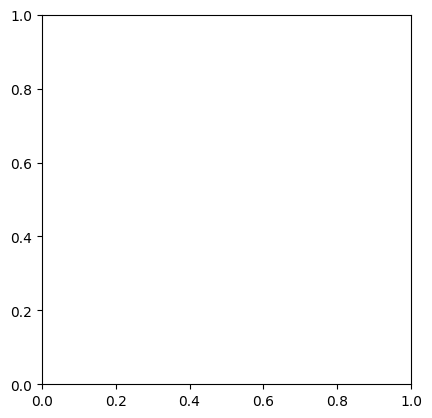

In [5]:
print (X_train[7].shape)
print (y_train.shape)

plt.imshow(X_train[7].squeeze(), cmap='gray')
plt.show()
X_train_a,y_train_a,alt_s=alt(X_train,y_train)
print (y_train_a.shape)
plt.imshow(X_train_a[7].squeeze(), cmap='gray')
plt.show()

print(alt_s)




frames = []
video_tensor=X_train
for i in range(video_tensor.shape[0]):
    # Convert each frame to a Pillow image object
    print(video_tensor[i].shape)
    im=video_tensor[i].squeeze()
    print(im.size)
    frame = Image.fromarray((im * 255 / np.max(im)).astype(np.uint8))
    frames.append(frame)

# Save the list of frames as a gif
imageio.mimsave('video_hela.gif', frames)

print(stop)

In [96]:
X_train_a,y_train_a,alt_s=alt(X_train,y_train,a=0,t_c=0)

save_im_tens(X_train_a,name='cyt_hela',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='cyt_hela',pos=True,alt=alt_s)

X_train_a,y_train_a,alt_s=alt(X_train,y_train,a=0,t_c=1)

save_im_tens(X_train_a,name='cyt_hela',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='cyt_hela',pos=True,alt=alt_s)

X_train_a,y_train_a,alt_s=alt(X_train,y_train,a=1,t_c=1)

save_im_tens(X_train_a,name='cyt_hela',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='cyt_hela',pos=True,alt=alt_s)

pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
shuffling
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos

In [98]:
X,y,alt_s=alt_vid(X_train,y_train,a=0)
print(alt_s)
save_vid_tens(X,name='tra_nh3',pos=False,alt=alt_s)
save_vid_tens(y,name='tra_nh3',pos=True,alt=alt_s)
    
    
X,y,alt_s=alt_vid(X_train,y_train,a=1)
print(alt_s)
save_vid_tens(X,name='tra_nh3',pos=False,alt=alt_s)
save_vid_tens(y,name='tra_nh3',pos=True,alt=alt_s)

i 0 0 0
i 1 0 0
i 2 0 0
i 3 0 0
i 4 0 0
i 5 0 0
i 6 0 0
i 7 0 0
i 8 0 0
i 9 0 0
i 10 0 0
i 11 0 0
i 12 0 0
i 13 0 0
i 14 0 0
i 15 0 0
i 16 0 0
i 17 0 0
i 18 0 0
0+0
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
po

In [95]:
path = '/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01/'
suff = 't' 

path2 = '/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01_GT/TRA/'
suff2='man_track'

X_train=tif_to_vt(path,suff)
y_train=tif_to_vt(path2,suff2)




X_train_a,y_train_a,alt_s=alt(X_train,y_train,t_c=0,a=0)

save_im_tens(X_train_a,name='hela_ctc',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='hela_ctc',pos=True,alt=alt_s)



X_train_a,y_train_a,alt_s=alt(X_train,y_train,t_c=0,a=1)

save_im_tens(X_train_a,name='hela_ctc',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='hela_ctc',pos=True,alt=alt_s)

pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2
pos2 2

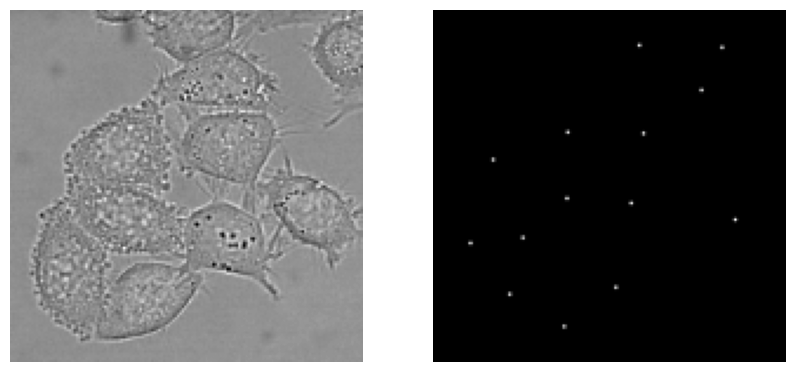

TypeError: Invalid shape (150,) for image data

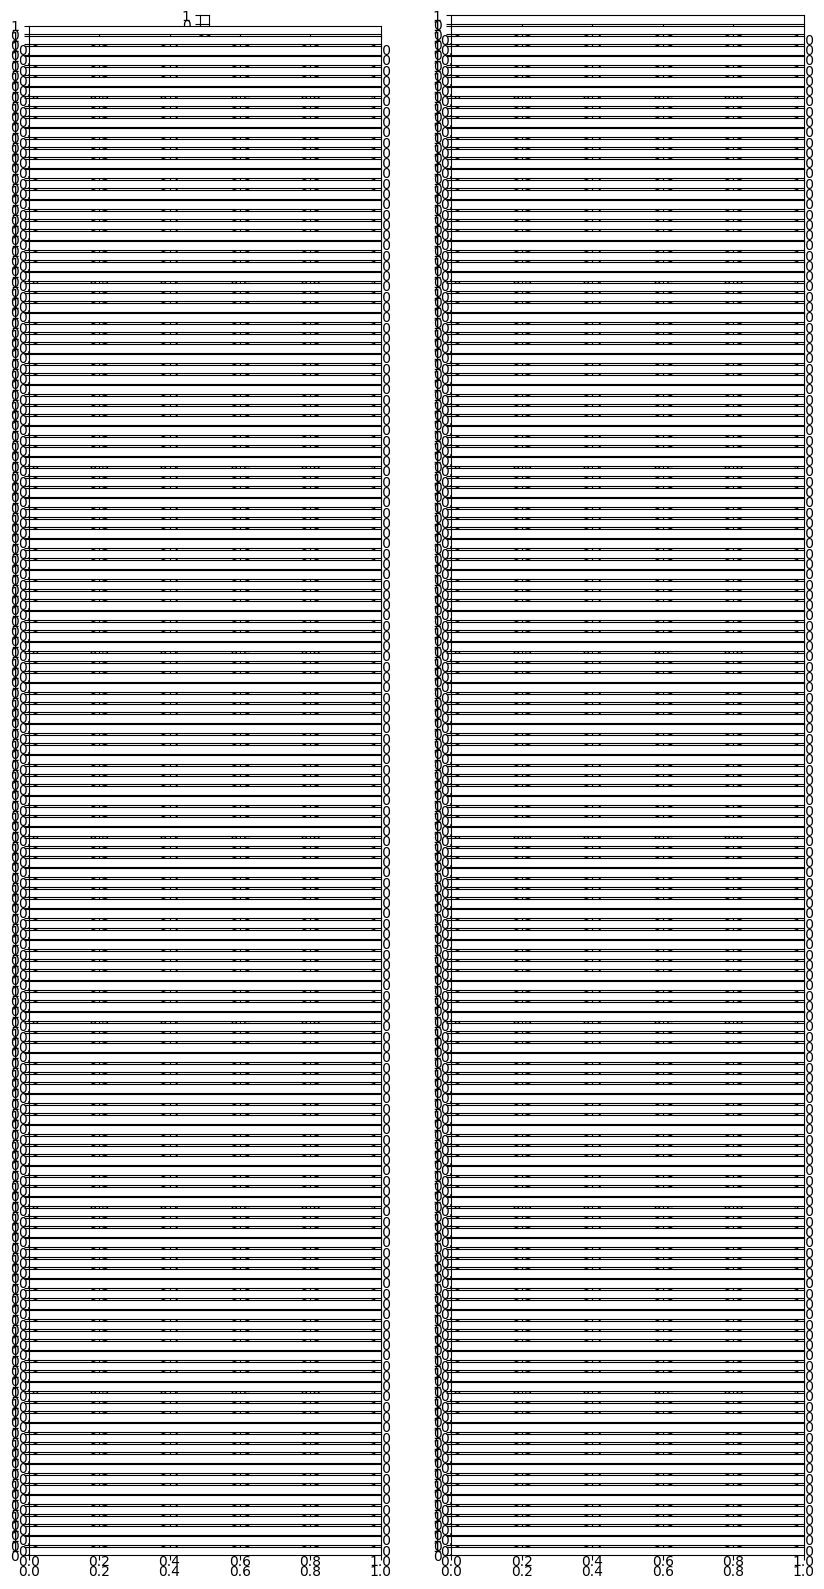

In [86]:
#52081.npy

#25822.npy

path1='/home/mo/Desktop/IWR/Cell_GT_Proj/emb_train/52081.npy'#'/home/mo/Desktop/IWR/Cell_GT_Proj/images/hela_ctc/alt0+1_2.npy'
path2='/home/mo/Desktop/IWR/Cell_GT_Proj/emb_train/25822.npy'

verify(path1,path2,single=True)